# Frechet random forests for Symmetric Positive Definite matrices (SPD)

In [1]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 

import matplotlib.pyplot as plt
# from ipywidgets import *

from typing import Union

import numpy as np
import pandas as pd
from scipy.linalg import expm
from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.preprocessing import MinMaxScaler
# from sklearn.model_selection import cross_val_score
# from sklearn.model_selection import GridSearchCV
# from sklearn import neighbors, clone


from pyfrechet.metric_spaces import MetricData, Euclidean, LogCholesky, spd_to_log_chol, log_chol_to_spd
# from pyfrechet.regression.frechet_regression import LocalFrechet, GlobalFrechet
# from pyfrechet.regression.kernels import NadarayaWatson, gaussian, epanechnikov
# from pyfrechet.regression.knn import KNearestNeighbours
from pyfrechet.regression.bagged_regressor import BaggedRegressor
from pyfrechet.regression.trees import Tree
from pyfrechet.metrics import mse

INFO: Using numpy backend


In [2]:
def sim_matrix_normal_one(M: np.ndarray, var: float,
                      random_state: Union[None, int]=None) -> np.ndarray:
    """
    Sample one observation from a symmetric matrix variate normal distribution with mean
    matrix M and variance parameter var. See:

    REFERENCE:
    Qi Zhang, Lingzhou Xue, and Bing Li. Dimension reduction for Fréchet regression. Journal of the
    American Statistical Association, pages 1-15, 2023.
    """
    d=M.shape[0]
    np.random.seed(random_state)
    Z=np.zeros(shape=(d,d))
    Z[np.diag_indices(d)]=np.random.normal(size=d, loc=0, scale=1)
    Z[np.tril_indices(d, k=-1)]=np.random.normal(size=np.tril_indices(d, k=-1)[0].size, loc=0, scale=0.5)
    Z[np.triu_indices(d, k=1)]=Z[np.tril_indices(d, k=-1)]
    A=M+np.sqrt(var)*Z
    return A

def sim_matrix_normal(M: np.ndarray, var: float,
                      size: int=1,
                      random_state: Union[None, int]=None) -> list:
    """
    Returns (a list) a sample of the size specified from a symmetric matrix variate normal distribution
    with mean matrix M and variance parameter var.
    (See sim_matrix_normal_one() function for details)
    """
    d=M.shape[0]
    np.random.seed(random_state)
    sample=[]

    for n in range(size):
        sample.append(sim_matrix_normal_one(M, var))
    return sample

In [117]:
# Some checkings
M=np.array([[1,2,3],
            [2,5,4],
            [3,4,0]])

sim_matrix_normal(M, 1, size=3, random_state=100)

[array([[1.73183679, 1.64352189, 3.1050673 ],
        [1.64352189, 3.81393386, 3.89406265],
        [3.1050673 , 3.89406265, 1.50385249]]),
 array([[0.59656439, 1.66517604, 3.34273242],
        [1.66517604, 5.17889745, 3.38975502],
        [3.34273242, 3.38975502, 0.03211604]]),
 array([[-0.28297526,  2.18016443,  2.8083158 ],
        [ 2.18016443,  5.71535414,  3.70793655],
        [ 2.8083158 ,  3.70793655, -0.17300143]])]

## Scenario 1

In [4]:
def rho(X: np.ndarray, beta: np.ndarray) -> float:
    return np.cos(4*np.pi*np.dot(X, beta))

def DX(X: np.ndarray, beta: np.ndarray) -> np.ndarray:
    """
    Return the matrix D(X) for predictor values X and parameter vector beta
    as in simulation of [1].

    REFERENCE:
    [1] Random Forest Weighted Local Frechet Regression (R. Yu)
    """
    return np.array([[1, rho(X, beta)],
                     [rho(X, beta), 1]])


In [5]:
beta2=np.array([0.75, 0.25])
beta5=np.array([0.1, 0.2, 0.3, 0.4, 0])
beta10=np.array([0.1, 0.2, 0.3, 0.4, 0, 0, 0, 0, 0, 0])
beta20=np.zeros(shape=20); beta20[[0,1,2,3]]=[0.1, 0.2, 0.3, 0.4]; beta20[[-4, -3, -2, -1]]=[0.1, 0.2, 0.3, 0.4]; beta20=beta20/2

In [6]:
def sim_DX(beta: np.ndarray, size: int) -> tuple[list, list]:
    """
    Function to sample predictors (X_1,...,X_p) following U([0,1]^p) with p=beta.size and its
    corresponding D(X) matrix (using DX() function above).
    It returns a tuple of two lists, one for the sample of predictors and other for the sample
    of matrices D(X).

    beta is the vector of parameters for the simulation and must be provided
    size is the number of samples to draw

    REFERENCE:
    [1] Random Forest Weighted Local Frechet Regression (R. Yu)
    """
    sampleX=[]
    sample=[]
    for n in range(size):
        X=np.random.uniform(size=beta.size)
        sampleX.append(X)
        sample.append(DX(X, beta))

    return (sampleX, sample)

In [7]:
sim_DX(beta2, size=3)

([array([0.32023914, 0.20923495]),
  array([0.59273498, 0.91800076]),
  array([0.42063656, 0.66853464])],
 [array([[ 1.        , -0.86081821],
         [-0.86081821,  1.        ]]),
  array([[ 1.        , -0.57810013],
         [-0.57810013,  1.        ]]),
  array([[1.        , 0.97622032],
         [0.97622032, 1.        ]])])

### $p=2$

In [8]:
sample_DX=sim_DX(beta2, size=100)
sample_logY=[]
for k in range(len(sample_DX[1])):
    sample_logY.append(sim_matrix_normal_one(M=sample_DX[1][k], var=0.2, random_state=100))

sample_logY

[array([[ 0.21748109, -0.74109491],
        [-0.74109491,  1.15325134]]),
 array([[0.21748109, 0.65872727],
        [0.65872727, 1.15325134]]),
 array([[0.21748109, 0.52939598],
        [0.52939598, 1.15325134]]),
 array([[ 0.21748109, -0.24414167],
        [-0.24414167,  1.15325134]]),
 array([[0.21748109, 0.49321896],
        [0.49321896, 1.15325134]]),
 array([[0.21748109, 0.91151499],
        [0.91151499, 1.15325134]]),
 array([[0.21748109, 1.22830721],
        [1.22830721, 1.15325134]]),
 array([[ 0.21748109, -0.70601296],
        [-0.70601296,  1.15325134]]),
 array([[0.21748109, 1.14717868],
        [1.14717868, 1.15325134]]),
 array([[0.21748109, 1.07347492],
        [1.07347492, 1.15325134]]),
 array([[0.21748109, 1.02000371],
        [1.02000371, 1.15325134]]),
 array([[ 0.21748109, -0.4253272 ],
        [-0.4253272 ,  1.15325134]]),
 array([[0.21748109, 0.52315058],
        [0.52315058, 1.15325134]]),
 array([[ 0.21748109, -0.40925363],
        [-0.40925363,  1.15325134]]),


In [9]:
sampleY=[expm(A) for A in sample_logY]
sampleY

[array([[ 1.74469924, -1.66635047],
        [-1.66635047,  3.84877681]]),
 array([[1.63539826, 1.4541953 ],
        [1.4541953 , 3.70118901]]),
 array([[1.49303833, 1.14019774],
        [1.14019774, 3.50847321]]),
 array([[ 1.29511204, -0.50730462],
        [-0.50730462,  3.23955917]]),
 array([[1.45932263, 1.0559505 ],
        [1.0559505 , 3.46274736]]),
 array([[2.02079454, 2.1424236 ],
        [2.1424236 , 4.22022765]]),
 array([[2.74028249, 3.20264012],
        [3.20264012, 5.18017317]]),
 array([[ 1.69630927, -1.57470967],
        [-1.57470967,  3.78347556]]),
 array([[2.52763248, 2.90533946],
        [2.90533946, 4.89755992]]),
 array([[2.35214308, 2.65167131],
        [2.65167131, 4.66365968]]),
 array([[2.23477885, 2.47661655],
        [2.47661655, 4.50687262]]),
 array([[ 1.40297545, -0.90144172],
        [-0.90144172,  3.38625405]]),
 array([[1.48703173, 1.12555173],
        [1.12555173, 3.50032935]]),
 array([[ 1.39093404, -0.86548705],
        [-0.86548705,  3.36989519]]),


In [14]:
X=np.c_[sample_DX[0]]
sampleY_LogChol=np.c_[[spd_to_log_chol(A) for A in sampleY]]
M=LogCholesky(dim=2)
y=MetricData(M, sampleY_LogChol)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [35]:
base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=2,
            min_split_size=1)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=4)
forest.fit(X_train, y_train)

BaggedRegressor(bootstrap_fraction=1, bootstrap_replace=True,
                estimator=Tree(min_split_size=1, mtry=2, split_type='2means'),
                n_jobs=4)

In [36]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

MSE: 0.5012228203660477
MSE: 0.3811726952030371


In [38]:
oob_errors=forest.oob_errors()

In [39]:
oob_errors

array([0.97658441, 0.98253475, 0.35478908, 0.42465132, 1.45957036,
       0.08072506, 0.47497636, 0.28151771, 0.76898019, 1.24909715,
       0.25443525, 0.91420518, 0.65508139, 0.28543696, 0.15704558,
       0.36566721, 0.31040367, 0.60475167, 0.29457168, 0.9925497 ,
       0.19034523, 0.50480358, 0.26014582, 0.17175448, 0.70297711,
       0.6798265 , 0.71310292, 0.40056673, 1.22513131, 0.34468514,
       0.43703333, 0.79059136, 1.3491647 , 1.17271482, 0.09462101,
       0.13856072, 0.11891418, 0.37516161, 0.56174851, 0.17899845,
       0.90194243, 0.57002473, 0.43857891, 0.1558132 , 0.18355958,
       0.45466577, 0.61140488, 0.87585081, 0.1463001 , 0.63578921,
       0.15456385, 0.53990254, 0.49710963, 0.98615919, 0.21087513,
       0.3452672 , 1.09690701, 0.37383664, 0.49210176, 0.37107439,
       1.01240415, 0.09367142, 0.88716337, 1.10169801, 0.6338472 ,
       0.58853856, 0.2627232 , 0.40262248, 0.62440952, 0.53869843,
       0.75251176, 0.31879664, 1.32243982, 0.41792424, 0.52929

In [40]:
alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha)

0.96

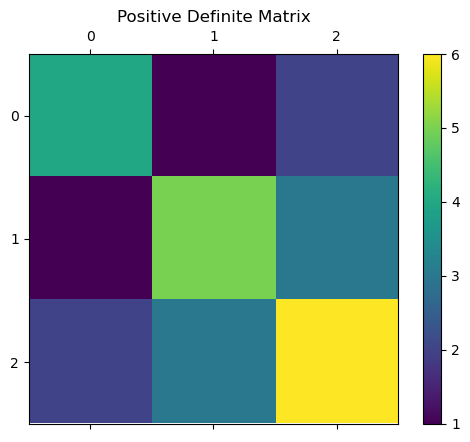

In [118]:
# IDEA FROM CHATGPT
def visualize_positive_definite_matrix(matrix):
    fig, ax = plt.subplots()
    cax = ax.matshow(matrix, cmap='viridis')

    # Add colorbar
    fig.colorbar(cax)

    plt.title('Positive Definite Matrix')
    plt.show()

# Example: visualize a 3x3 positive definite matrix
matrix = np.array([[4, 1, 2],
                   [1, 5, 3],
                   [2, 3, 6]])

visualize_positive_definite_matrix(matrix)

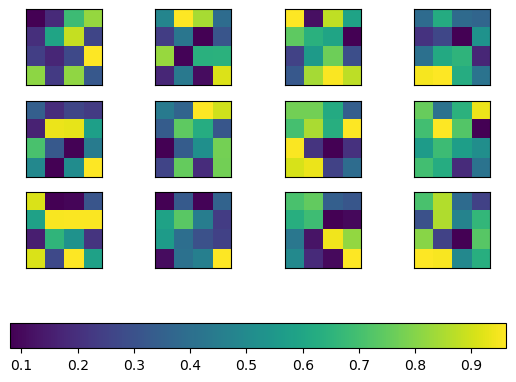

In [15]:
def visualize_positive_definite_matrices(matrices, layout: Union[tuple, None]=None):
    """
    layout=(num_rows, num_cols)
    """
    if not layout:
        num_cols = int(np.ceil(np.sqrt(num_matrices)))
        num_rows = int(np.ceil(num_matrices / num_cols))
    else:
        num_rows=layout[0]
        num_cols=layout[1]

    fig, axs = plt.subplots(num_rows, num_cols)

    # Loop through the matrices and plot them
    for i, matrix in enumerate(matrices):
        row = i // num_cols
        col = i % num_cols
        ax = axs[row, col]
        cax = ax.matshow(matrix, cmap='viridis')
        # ax.set_title(f'Matrix {i+1}')

        ax.set_xticks([])
        ax.set_yticks([])

    # Create a single colorbar for all matrices
    fig.colorbar(cax, ax=axs.ravel().tolist(), location='bottom')
    plt.show()

# Example: visualize multiple 3x3 positive definite matrices
matrix_size = 4
num_matrices = 12
matrices = [np.random.rand(matrix_size, matrix_size) for _ in range(num_matrices)]
visualize_positive_definite_matrices(matrices)

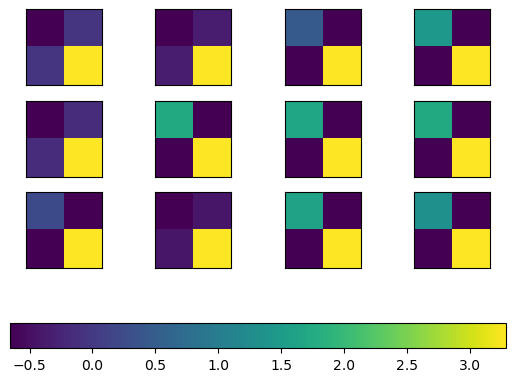

In [50]:
# fig, ax = plt.subplots(1,2)
# ax[0].matshow(log_chol_to_spd(y_test.data[15]), cmap='viridis')
# ax[1].matshow(log_chol_to_spd(forest_predictions.data[15]), cmap='viridis')

# # Add colorbar
# # fig.colorbar(cax)
# plt.show()

matrices_to_plot=[]
index_to_plot=range(12)
for i in index_to_plot:
    matrices_to_plot.append(log_chol_to_spd(y_test.data[i]))
visualize_positive_definite_matrices(matrices=matrices_to_plot)

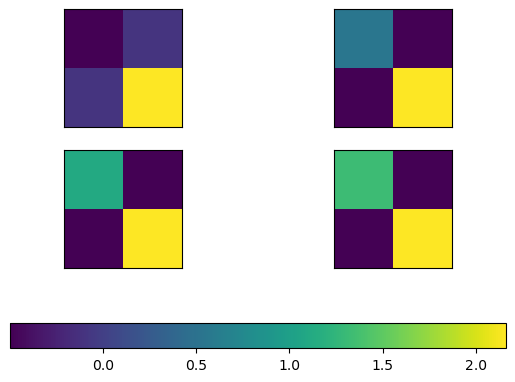

In [43]:
matrices_to_plot=[]
index_to_plot=[0,5]
for i in index_to_plot:
    matrices_to_plot.append(log_chol_to_spd(y_test.data[i]))
    matrices_to_plot.append(log_chol_to_spd(forest_predictions.data[i]))
visualize_positive_definite_matrices(matrices=matrices_to_plot, layout=(len(index_to_plot),2))

In [32]:
Dalpha

7.529495971530416

In [15]:
M=LogCholesky(2)
M.d(sampleY[0], sampleY[1])

4.521712579987448

In [20]:
M=LogCholesky(4)
A=spd_to_log_chol(sampleY[0])
B=spd_to_log_chol(sampleY[1])
M.d(A, B)

2.4340564518486407

array([ 0.23825258,  0.44711363, -1.10543785])

In [ ]:
np.linalg.norm()

### $p=10$

In [11]:
sample_DX=sim_DX(beta10, size=250)
sample_logY=[]
for k in range(len(sample_DX[1])):
    sample_logY.append(sim_matrix_normal_one(M=sample_DX[1][k], var=0.2**2, random_state=100))

sampleY=[expm(A) for A in sample_logY]

X=np.c_[sample_DX[0]]
sampleY_LogChol=np.c_[[spd_to_log_chol(A) for A in sampleY]]
M=LogCholesky(dim=10)
y=MetricData(M, sampleY_LogChol)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [12]:
base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=3, # Take sqrt(predictor variables)
            min_split_size=1)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=4)
forest.fit(X_train, y_train)

BaggedRegressor(bootstrap_fraction=1, bootstrap_replace=True,
                estimator=Tree(min_split_size=1, mtry=3, split_type='2means'),
                n_jobs=4)

In [43]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

oob_errors=forest.oob_errors()

alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha)

MSE: 1.4591901872751496
MSE: 0.5520137635651695


0.9206349206349206

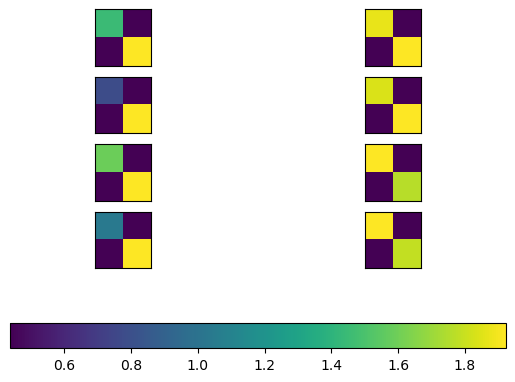

In [16]:
matrices_to_plot=[]
for i in [0,10,20,24]:
    matrices_to_plot.append(log_chol_to_spd(y_test.data[i]))
    matrices_to_plot.append(log_chol_to_spd(forest_predictions.data[i]))
visualize_positive_definite_matrices(matrices=matrices_to_plot, layout=(4,2))

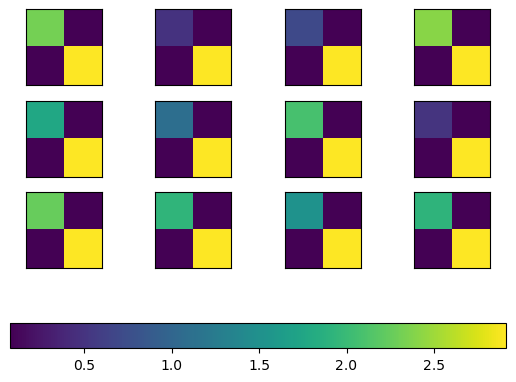

In [17]:
visualize_positive_definite_matrices(sampleY[2:14])

## Scenario 2

In [33]:
def rho1(X: np.ndarray, beta1: np.ndarray) -> float:
    return 0.8*np.cos(4*np.pi*np.dot(X, beta1))

def rho2(X: np.ndarray, bata2: np.ndarray) -> float:
    return 0.4*np.cos(4*np.pi*np.dot(X, beta2))

def DX(X: np.ndarray, beta1: np.ndarray, beta2: np.ndarray) -> np.ndarray:
    return np.array([[1, rho1(X, beta1), rho2(X, beta2)],
                     [rho1(X, beta1), 1, rho1(X, beta1)],
                     [rho2(X, beta2), rho1(X, beta1), 1]])

def sim_DX(beta1: np.ndarray, beta2: np.ndarray, size: int) -> tuple[list, list]:
    """
    Function to sample predictors (X_1,...,X_p) following U([0,1]^p) with p=beta.size and its
    corresponding D(X) matrix (using DX() function above).
    It returns a tuple of two lists, one for the sample of predictors and other for the sample
    of matrices D(X).

    beta is the vector of parameters for the simulation and must be provided
    size is the number of samples to draw

    REFERENCE:
    [1] Random Forest Weighted Local Frechet Regression (R. Yu)
    """
    sampleX=[]
    sample=[]
    for n in range(size):
        X=np.random.uniform(size=beta.size)
        sampleX.append(X)
        sample.append(DX(X, beta1, beta2))

    return (sampleX, sample)

In [34]:
beta1_2=np.array([0.75, 0.25]); beta2_2=np.array([0.75, 0.25])
beta1_5=np.array([0.1, 0.2, 0.3, 0.4, 0]); beta2_5=np.array([0, 0.1, 0.2, 0.3, 0.4])
beta1_10=np.array([0.1, 0.2, 0.3, 0.4, 0, 0, 0, 0, 0, 0]); beta2_10=np.array([0, 0, 0, 0, 0, 0, 0.1, 0.2, 0.3, 0.4])
beta1_20=np.zeros(shape=20); beta1_20[[0,1,2,3]]=[0.1, 0.2, 0.3, 0.4]
beta2_20=np.zeros(shape=20); beta2_20[[-4,-3,-2,-1]]=[0.1, 0.2, 0.3, 0.4]


### $p=10$

In [ ]:
sample_DX=sim_DX(beta1_10, beta2_10, size=250)
sample_logY=[]
for k in range(len(sample_DX[1])):
    sample_logY.append(sim_matrix_normal_one(M=sample_DX[1][k], var=0.2**2, random_state=100))

sampleY=[expm(A) for A in sample_logY]

X=np.c_[sample_DX[0]]
sampleY_LogChol=np.c_[[spd_to_log_chol(A) for A in sampleY]]
M=LogCholesky(dim=10)
y=MetricData(M, sampleY_LogChol)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=3, # Take sqrt(predictor variables)
            min_split_size=1)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=4)
forest.fit(X_train, y_train)

In [ ]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

oob_errors=forest.oob_errors()

alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha)

In [ ]:
matrices_to_plot=[]
for i in [0,10,20,24]:
    matrices_to_plot.append(log_chol_to_spd(y_test.data[i]))
    matrices_to_plot.append(log_chol_to_spd(forest_predictions.data[i]))
visualize_positive_definite_matrices(matrices=matrices_to_plot, layout=(4,2))

In [ ]:
visualize_positive_definite_matrices(sampleY[2:14])

### $p=20$

In [ ]:
sample_DX=sim_DX(beta1_20, beta2_20, size=250)
sample_logY=[]
for k in range(len(sample_DX[1])):
    sample_logY.append(sim_matrix_normal_one(M=sample_DX[1][k], var=0.2**2, random_state=100))

sampleY=[expm(A) for A in sample_logY]

X=np.c_[sample_DX[0]]
sampleY_LogChol=np.c_[[spd_to_log_chol(A) for A in sampleY]]
M=LogCholesky(dim=10)
y=MetricData(M, sampleY_LogChol)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=100)

scaler=MinMaxScaler(feature_range=(0,1))
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

In [ ]:
base = Tree(split_type='2means',
            impurity_method='cart',
            mtry=4, # Take sqrt(predictor variables)
            min_split_size=1)
forest = BaggedRegressor(estimator=base,
                         n_estimators=100,
                         bootstrap_fraction=1,
                         bootstrap_replace=True,
                         n_jobs=4)
forest.fit(X_train, y_train)

In [ ]:
forest_predictions = forest.predict(X_test)
print(f'MSE: {mse(y_test, forest_predictions)}')

forest_fitted = forest.predict(X_train)
print(f'MSE: {mse(y_train, forest_fitted)}')

oob_errors=forest.oob_errors()

alpha=0.05
Dalpha=np.percentile(oob_errors, (1-alpha)*100)
np.mean(y_train.M.d(forest_predictions.data, y_test.data) <= Dalpha)

In [ ]:
matrices_to_plot=[]
for i in [0,10,20,24]:
    matrices_to_plot.append(log_chol_to_spd(y_test.data[i]))
    matrices_to_plot.append(log_chol_to_spd(forest_predictions.data[i]))
visualize_positive_definite_matrices(matrices=matrices_to_plot, layout=(4,2))

In [ ]:
visualize_positive_definite_matrices(sampleY[2:14])